In [ ]:
#必要なパッケージをインストール
!pip install kaggle
!apt install -y ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
#データセットを置くドライブを設定する
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#kaggle.jsonを使った認証
import os
import json
f = open("/content/drive/MyDrive/kaggle.json", 'r')
json_data = json.load(f) 
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [ ]:
#kaggle APIを用いてデータセットをダウンロードして解凍
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip '/content/gtzan-dataset-music-genre-classification.zip'

100% 1.21G/1.21G [00:55<00:00, 25.2MB/s]
100% 1.21G/1.21G [00:55<00:00, 23.5MB/s]
Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/gen

In [ ]:
#必要なモジュールを準備
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa as lb
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers, callbacks
from tensorflow.keras.layers.experimental import preprocessing

import IPython
import IPython.display as ipd

In [ ]:
#データが含まれているフォルダを指定
path = "/content/Data/genres_original"

#フォルダ名（＝楽曲ジャンル）からラベルのリストを作成する
labels = [f.name for f in os.scandir(path) if f.is_dir()]

#ラベルごとにOne-hotベクトルを定義する
indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

n_files = 0
for folder in labels:
    files = os.listdir(path+"/"+folder)
    for file in files:
        if file.split('.')[-1] == 'wav':
            n_files += 1

#ダウンロードしたデータの数を表示する
#無効なデータを削除したため999個            
print(f'n_files: {n_files}')

['jazz', 'classical', 'metal', 'disco', 'reggae', 'country', 'rock', 'hiphop', 'blues', 'pop']
jazz [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
classical [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
metal [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
disco [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
reggae [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
country [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
rock [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
hiphop [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
blues [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
pop [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
n_files: 999


In [ ]:
#グローバル変数を定義

H = 128 #テンソルの高さ
N_FEATURES = 1 #テンソルのチャネル数
N_FILES = n_files #ダウンロードしたデータ数
N_SLICES = 3 #データを切り分ける数
AUG_FEATURES = 5 #ピッチシフト、タイムストレッチ、ノイズ追加で増やすデータ数

#データの総数
M = N_FILES * N_SLICES * (AUG_FEATURES + 1) 

In [ ]:
#学習・検証・評価に用いるデータを作成する
#水増しする際に使う関数を定義

#音声データを読み込む関数
def read_sample(file):
    y, sr = lb.load(file)
    return y, sr

#音声データを試聴するための関数
def listen_sample(sample, sr=22050):
    return IPython.display.display(ipd.Audio(data=sample, rate=sr))

#データを水増しするための関数
#read_sample関数の返り値y, srから
def augment_sample(sample, sr):

    augmented_samples = list()

    #1. 音声データを分割し、以下の処理を行う
    samples = np.array_split(sample, N_SLICES)
    
    for sample_ in samples:

        #2. 無加工のままリストに追加
        augmented_samples.append(sample_)

        #3. ピッチシフト：5半音上げたものと5半音下げたものをリストに追加
        augmented_samples.append(lb.effects.pitch_shift(sample_, sr=sr, n_steps=5))
        augmented_samples.append(lb.effects.pitch_shift(sample_, sr=sr, n_steps=-5))

        #4. タイムストレッチ：0.8倍・1.5倍したものをリストに追加
        augmented_samples.append(lb.effects.time_stretch(sample_, rate=0.8))
        augmented_samples.append(lb.effects.time_stretch(sample_, rate=1.5))

        #5. ホワイトノイズを追加したものをリストに追加
        wn = np.random.randn(len(sample_))
        augmented_samples.append(sample_ + 0.005*wn)
    
    return augmented_samples

#分割した直後のデータの長さを取得
def get_input_length(path, folders):

    folder = folders[0]
    files = os.listdir(path+"/"+folder)
    input_length = 0
    for file in files:
        if file.split('.')[-1] == 'wav':
            sample, sr = read_sample(path+"/"+folder+'/'+file)
            input_length = len(sample) // N_SLICES
            break
        
    
    return input_length


def get_n_frames(sample, sr):
    mel = lb.feature.melspectrogram(y=sample, sr=sr)
    print(mel.shape)
    return mel.shape[1]
    
#水増し済みデータ（まだ波形の状態）の長さを無加工のものと揃えて返す関数    
def read_raw_data(path, folders):

    input_length = get_input_length(path, folders)
    
    x_raw = np.zeros((M, input_length))
    y_raw = np.zeros((M, 10))
    print(x_raw.shape, y_raw.shape)
    i = 0
    for folder in folders:
        print(f"Reading {folder}")
        files = os.listdir(path+"/"+folder)
        for file in files:
            
            if file.split('.')[-1] == 'wav':
                sample, sr = read_sample(path+"/"+folder+'/'+file)
                aug_samples = augment_sample(sample, sr)
                for sample_ in aug_samples: 
                    # 長さをそろえる
                    if len(sample_) > input_length:
                        sample_ = sample_[:input_length]
                    else:
                        sample_ = np.pad(sample_, (0, max(0, input_length - len(sample_))))
                    x_raw[i,:] = sample_
                    y_raw[i,:] = oh_dict[folder]
                    i += 1
    print('Samples read: ', i)
    return x_raw, y_raw, sr


#メルスペクトログラムに変換し、データセットを作成する関数
def create_dataset(x_raw, sr):

    n_frames = get_n_frames(x_raw[0,:], sr)
    X = np.zeros((M, 128, n_frames, N_FEATURES))

    for i in range(M):
        sample = x_raw[i,:]
        mel = lb.feature.melspectrogram(y=sample, sr=sr)
        spect = lb.power_to_db(mel, ref=1.0)
        norm_spect = normalize(spect)
        X[i,:,:,0] = norm_spect

                
    return X

In [ ]:
# 分割＆水増ししたデータを読み込む

x_raw, y_raw, sr = read_raw_data(path, labels)
print(x_raw.shape, y_raw.shape)


(17982, 220598) (17982, 10)
Reading jazz
Reading classical
Reading metal
Reading disco
Reading reggae
Reading country
Reading rock
Reading hiphop
Reading blues
Reading pop
Samples read:  17982
(17982, 220598) (17982, 10)


In [ ]:
#.npyファイルの保存＆読込、学習済みモデルの保存のためにカレントディレクトリを指定
%cd /content/drive/MyDrive

/content/drive/MyDrive


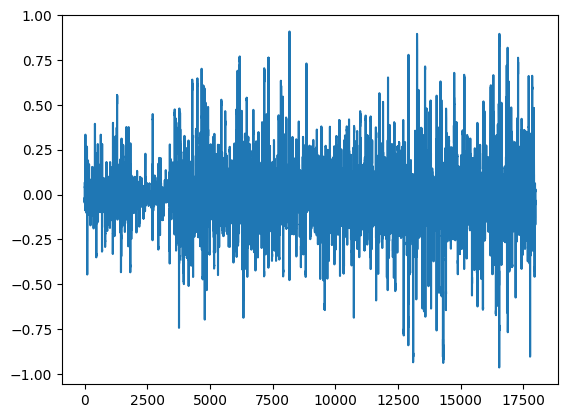

In [ ]:
#適当なデータの波形を表示
plt.plot(x_raw[:, 12])

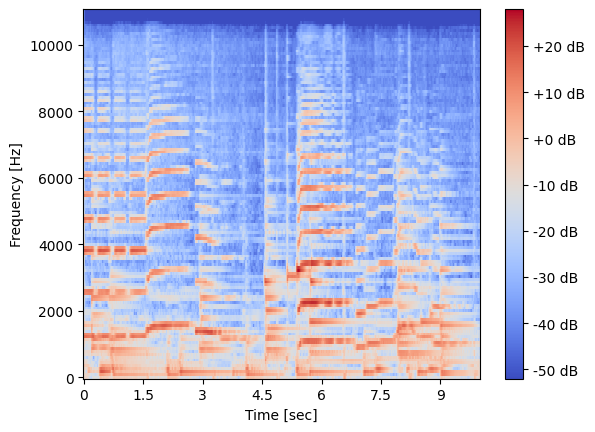

In [ ]:
#同じデータのメルスペクトログラムを表示
mel = lb.feature.melspectrogram(y=x_raw[12, :], sr=sr)
spect = lb.power_to_db(mel, ref=1.0)

lb.display.specshow(spect, sr=sr, x_axis="time", y_axis="hz")
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(format="%+2.f dB")
plt.show()

In [ ]:
#そのデータを再生できる
listen_sample(x_raw[12, :], sr=22050)

In [ ]:
# Creating the tensor with the features

X = create_dataset(x_raw, sr)
Y = np.copy(y_raw)
print(X.shape)
print(Y.shape)

(128, 431)
(17982, 128, 431, 1)
(17982, 10)


In [ ]:
assert X.shape[0] == Y.shape[0], "X, Y shapes don't match"
assert Y.shape[1] == len(labels), "Y shape doesn't match the shape of the labels"

In [ ]:
# Train, validation, test split
# ------------
# 80% for training, 20% for validation and 10% for testing

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_test_valid,y_test_valid, test_size=0.5)

print(f'Train: {X_train.shape} {y_train.shape}')
print(f'Valid: {X_val.shape}   {y_val.shape}')
print(f'Test:  {X_test.shape}  {y_test.shape}')


Train: (14385, 128, 431, 1) (14385, 10)
Valid: (1798, 128, 431, 1)   (1798, 10)
Test:  (1799, 128, 431, 1)  (1799, 10)


In [ ]:
n_filters = 64
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape) 

x = layers.Conv2D(n_filters, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model4 = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model4.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 429, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 214, 64)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 214, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 212, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 106, 64)      0         
 2D)                                                         

Epoch 1/30
450/450 [==============================] - 22s 21ms/step - loss: 1.7871 - accuracy: 0.3515 - val_loss: 1.3810 - val_accuracy: 0.5017
Epoch 2/30
450/450 [==============================] - 8s 18ms/step - loss: 1.3033 - accuracy: 0.5385 - val_loss: 1.1330 - val_accuracy: 0.6034
Epoch 3/30
450/450 [==============================] - 8s 17ms/step - loss: 1.0454 - accuracy: 0.6331 - val_loss: 0.9907 - val_accuracy: 0.6602
Epoch 4/30
450/450 [==============================] - 8s 17ms/step - loss: 0.8616 - accuracy: 0.7029 - val_loss: 0.9128 - val_accuracy: 0.7069
Epoch 5/30
450/450 [==============================] - 8s 17ms/step - loss: 0.7190 - accuracy: 0.7504 - val_loss: 0.7579 - val_accuracy: 0.7369
Epoch 6/30
450/450 [==============================] - 8s 17ms/step - loss: 0.6045 - accuracy: 0.7859 - val_loss: 0.7323 - val_accuracy: 0.7481
Epoch 7/30
450/450 [==============================] - 8s 17ms/step - loss: 0.5341 - accuracy: 0.8126 - val_loss: 0.6502 - val_accuracy: 0.789

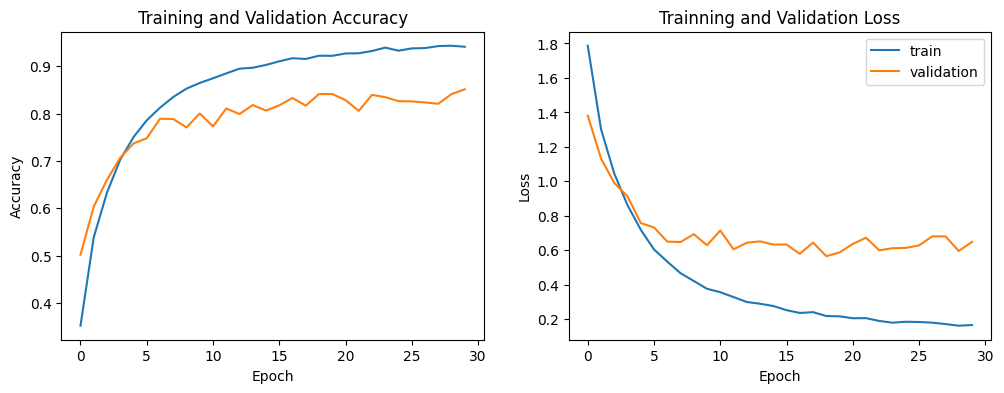

In [ ]:
history_model4 = model4.fit(x=X_train, 
                          y=y_train,
                          validation_data=(X_val, y_val),
                          epochs=30,
                          shuffle=True)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(history_model4.history['accuracy'], label='train')
ax1.plot(history_model4.history['val_accuracy'], label='validation')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

ax2.plot(history_model4.history["loss"], label="train")
ax2.plot(history_model4.history["val_loss"], label="validation")
ax2.set_title("Trainning and Validation Loss")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
score = model4.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

57/57 [==============================] - 0s 8ms/step - loss: 0.6473 - accuracy: 0.8410
Test loss: 0.6472892165184021
Test accuracy: 0.841022789478302


In [ ]:
from google.colab import files

result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
# 重みを保存
model4.save(os.path.join(result_dir, 'model.h5'))

# アプリ実装用に学習済みモデルのファイルをダウンロード
files.download('/content/drive/MyDrive/results/model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# モデルのinput_shapeに対応したメルスペクトグラムをNumPy配列で返す関数
def pad_mel(mel, input_shape):

    input_length = input_shape[2]
    if mel.shape[1] == input_length:
        return mel

    elif mel.shape[1] > input_length:
        mel = mel[:,:input_length]
    else:
        mel = np.pad(mel, (0, max(0, mel- len(mel))))
    return mel

In [ ]:
#ジャンルを分類する関数を定義
def pred_music_genre(path_file):

        sample, sr = read_sample(path_file)
        mel = lb.feature.melspectrogram(y=sample, sr=sr)
        spect = lb.power_to_db(mel, ref=1.0)
        norm_spect = normalize(spect)

        model = models.load_model('/content/drive/MyDrive/results/model.h5')
        input_shape = model.layers[0].output_shape[0]

        x = pad_mel(norm_spect, input_shape)
        x = np.reshape(x, (1, input_shape[1], input_shape[2], input_shape[3]))

        pred_index = np.argmax(model.predict(x))
        pred_label = labels[pred_index]
        print("予想されたジャンル:" + pred_label)

In [ ]:
# 任意のwavファイルを追加する
pred_music_genre("___")

In [ ]:
#以下はただのメモです
def pred_music_genre(path_file):

    sample, sr = read_sample(path_file)
    mel = lb.feature.melspectrogram(y=sample, sr=sr)
    spect = lb.power_to_db(mel, ref=1.0)
    norm_spect = normalize(spect)

    input_shape = model.layers[0].output_shape[0]

    x = pad_mel(norm_spect, input_shape)
    x = np.reshape(x, (1, input_shape[1], input_shape[2], input_shape[3]))

    pred_index = np.argmax(model.predict(x))
    pred_label = labels[pred_index]
    print("予想されたジャンル:" + pred_label)